# Dialogue Act Tagging

Dialogue act (DA) tagging is an essential step in the development of dialog systems. DA tagging is a problem that is usually solved using supervised machine learning techniques, which all require a large amount of manually labeled data. For DA tagging, a variety of methods have been investigated. In this lab, we'll look at two different DA classification models. The Switchboard Dialog Act Corpus is being used for training.
Corpus can be downloaded from http://compprag.christopherpotts.net/swda.html.


In [1]:
!wget 'https://github.com/juntaoy/ECS7001_LAB_DATASETS/raw/refs/heads/main/DA_data.zip'
!unzip DA_data.zip -x __MACOSX/*

--2025-04-23 13:45:49--  https://github.com/juntaoy/ECS7001_LAB_DATASETS/raw/refs/heads/main/DA_data.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 

302 Found
Location: https://raw.githubusercontent.com/juntaoy/ECS7001_LAB_DATASETS/refs/heads/main/DA_data.zip [following]
--2025-04-23 13:45:49--  https://raw.githubusercontent.com/juntaoy/ECS7001_LAB_DATASETS/refs/heads/main/DA_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14495014 (14M) [application/zip]
Saving to: ‘DA_data.zip’

DA_data.zip         100%[===================>]  13.82M  --.-KB/s    in 0.08s   

2025-04-23 13:45:49 (184 MB/s) - ‘DA_data.zip’ saved [14495014/14495014]

Archive:  DA_data.zip
   creating: swda/
   creating: swda/sw10utt/
   creating: swda/sw00utt/
   creating: swda/sw04utt/
  inflating: swda/.DS_Store          
   creating: swda/sw05utt/
   creating: swda/sw11utt/
   creating: swda/sw01utt/
  inflating: swda/swda-met

The downloaded dataset should be kept in a data folder in the same directory as this file.

In [1]:
! pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, TensorDataset

import glob
import re
import pandas as pd
import numpy as np
import sklearn.metrics
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [3]:
f = glob.glob("swda/sw*/sw*.csv")
frames = []
for i in range(0, len(f)):
    frames.append(pd.read_csv(f[i]))

result = pd.concat(frames, ignore_index=True)


In [4]:
print("Number of converations in the dataset:",len(result))


Number of converations in the dataset: 223606


The dataset has many different features, we are only using act_tag and text for this training.


In [5]:
reduced_df = result[['act_tag','text']]


Reduce the number of tags to 43 by combining them and converting them to generic tags.

In [6]:
# Imported from "https://github.com/cgpotts/swda"
# Convert the combination tags to the generic 43 tags

import re
def damsl_act_tag(input):
        """
        Seeks to duplicate the tag simplification described at the
        Coders' Manual: http://www.stanford.edu/~jurafsky/ws97/manual.august1.html
        """
        d_tags = []
        tags = re.split(r"\s*[,;]\s*", input)
        for tag in tags:
            if tag in ('qy^d', 'qw^d', 'b^m'): pass
            elif tag == 'nn^e': tag = 'ng'
            elif tag == 'ny^e': tag = 'na'
            else:
                tag = re.sub(r'(.)\^.*', r'\1', tag)
                tag = re.sub(r'[\(\)@*]', '', tag)
                if tag in ('qr', 'qy'):                         tag = 'qy'
                elif tag in ('fe', 'ba'):                       tag = 'ba'
                elif tag in ('oo', 'co', 'cc'):                 tag = 'oo_co_cc'
                elif tag in ('fx', 'sv'):                       tag = 'sv'
                elif tag in ('aap', 'am'):                      tag = 'aap_am'
                elif tag in ('arp', 'nd'):                      tag = 'arp_nd'
                elif tag in ('fo', 'o', 'fw', '"', 'by', 'bc'): tag = 'fo_o_fw_"_by_bc'
            d_tags.append(tag)
        # Dan J says (p.c.) that it makes sense to take the first;
        # there are only a handful of examples with 2 tags here.
        return d_tags[0]

In [7]:
reduced_df["act_tag"] = reduced_df["act_tag"].apply(lambda x: damsl_act_tag(x))

/tmp/ipykernel_7496/1040889475.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df["act_tag"] = reduced_df["act_tag"].apply(lambda x: damsl_act_tag(x))


This dataset contains 43 tags. Yes-No-Question ('qy'), Statement-non-opinion ('sd'), and Statement-opinion ('sv') are some of the tags. Tags information can be found here http://compprag.christopherpotts.net/swda.html#tags.


You can check the frequency of tags.

To get unique tags:

In [8]:
unique_tags = set()
for tag in reduced_df['act_tag']:
    unique_tags.add(tag)

In [9]:
tag_dict = {t:i for i,t in enumerate(list(unique_tags))}

In [10]:
tags_encoding = []
for i in range(0, len(reduced_df)):
    tags_encoding.append(tag_dict[reduced_df['act_tag'].iloc[i]])

The tags are one hot encoded.

To create sentence embeddings:

In [11]:
sentences = []
for i in range(0, len(reduced_df)):
    sentences.append(reduced_df['text'].iloc[i].split(" "))


In [12]:
wordvectors = {}
index = 1
for s in sentences:
    for w in s:
        if w not in wordvectors:
            wordvectors[w] = index
            index += 1

In [13]:
sentence_embeddings = []
for s in sentences:
    sentence_emb = []
    for w in s:
        sentence_emb.append(wordvectors[w])
    sentence_embeddings.append(sentence_emb)


The dataset is divided into two sections: test and training.

In [14]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings, np.array(tags_encoding),shuffle=False, stratify=None)


Pad each utterance to make them all the same length.




In [15]:
MAX_LENGTH = 150

In [16]:
print(X_train[1],y_train[1])

[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 19, 22, 23, 24, 24, 4, 25, 26, 27, 24, 6] 32


In [17]:
def pad_sequences(sequences, maxlen):
    return [seq[:maxlen] + [0] * (maxlen - len(seq)) for seq in sequences]

train_sentences_X = pad_sequences(X_train, maxlen=MAX_LENGTH)
test_sentences_X = pad_sequences(X_test, maxlen=MAX_LENGTH)

In [18]:
# Split Train into Train and Validation - about 10% into validation - In order to validate the model as it is training

train_input = train_sentences_X[:140000]
val_input = train_sentences_X[140000:]

train_labels = y_train[:140000]
val_labels = y_train[140000:]


In [19]:
np.array(train_input[11052])


array([105,   6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0])

In [20]:
sentence_embeddings[11052]

[105, 6]

In [21]:
train_labels[11052]

23

# Model 1 -

This first model has an architecture of:

- Embedding  
- BLSTM  
- Fully Connected Layer

The model architecture is as follows: Embedding Layer (to generate word
embeddings). Next layer Bidirectional LSTM. Feed forward layer with number of neurons = number of tags.


In [22]:
VOCAB_SIZE = len(wordvectors)+1 # 43,731
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags)

In [42]:
class BiLSTMModel(nn.Module):
    """
    Task 1 1/4

    Begin
    """
    def __init__(self,vocab_size, embed_size, hidden_size, max_length):
        super(BiLSTMModel, self).__init__()

        # Include 2 BLSTM layers, in order to capture both the forward and backward hidden states

        # Embedding layer
        # Bidirectional 1
        # Bidirectional 2
        # Dense layer

        self.embedder= nn.Embedding(vocab_size, embed_size)

        self.lstm1 = nn.LSTM(input_size=embed_size, hidden_size=hidden_size,
                        batch_first=True, bidirectional=True)

        self.lstm2 = nn.LSTM(input_size=2*hidden_size, hidden_size=hidden_size,
                        batch_first=True, bidirectional=True)

        self.dense = nn.Linear(2 * hidden_size, hidden_size)



    def forward(self, x):
        """
        x shape: (batch_size, seq_length)
        """
        out2 = self.embedder(x)
        out2, _ = self.lstm1(out2)
        out2, _ = self.lstm2(out2)

        # sentence_representation = x[:, -1, :]
        # probs = self.dense_layer(sentence_representation)

        # return probs

        idx = (x != 0).sum(1).clamp(min=1) - 1

        out = out2[torch.arange(out2.size(0)), idx]

        return self.dense(out)
    """
    End Task 1 1/4
    """

# Instantiate the model
model = BiLSTMModel(
    vocab_size=VOCAB_SIZE,
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    max_length=MAX_LENGTH
)
# Print model summary (PyTorch-style)
print(model)

BiLSTMModel(
  (embedder): Embedding(43732, 100)
  (lstm1): LSTM(100, 43, batch_first=True, bidirectional=True)
  (lstm2): LSTM(86, 43, batch_first=True, bidirectional=True)
  (dense): Linear(in_features=86, out_features=43, bias=True)
)


In [43]:
train_input_t = torch.Tensor(train_input)
train_labels_t = torch.Tensor(train_labels)
val_input_t = torch.Tensor(val_input)
val_labels_t = torch.Tensor(val_labels)
test_sentences_X_t = torch.Tensor(test_sentences_X)
y_test_t = torch.Tensor(y_test)

train_dataset = TensorDataset(train_input_t, train_labels_t)
val_dataset = TensorDataset(val_input_t, val_labels_t)
test_dataset = TensorDataset(test_sentences_X_t, y_test_t)

In [49]:
def train(model, train_dataset, val_dataset, epoch_num, lr, batch_size=1, device="cpu", weight=None):
    model.train()
    model = model.to(device)
    if weight:
       weight = torch.Tensor(weight).to(device)
    criterion = nn.CrossEntropyLoss(weight=weight).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epoch_num):
      model.train()
      total_loss = 0.0
      correct = 0
      """
      Task 1 2/3

      Begin
      """
      for batch_x, batch_y in train_loader:

          batch_x = batch_x.to(torch.int32).to(device)
          batch_y = batch_y.type(torch.LongTensor).to(device)


          # calculate the loss
          # backpropagation
          # compute the training accuracy

          #perform fwd pass
          outputs = model(batch_x)
          loss = criterion(outputs, batch_y.long())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          total_loss += loss.item()
          predicted = torch.argmax(outputs,dim = 1)
          correct += (predicted == batch_y).sum().item()





      avg_loss = total_loss / len(train_dataset)
      accuracy = correct / len(train_dataset)

      # Validation
      model.eval()
      val_loss = 0.0
      val_correct = 0
      with torch.no_grad():
          for val_x, val_y in val_loader:
              val_x = val_x.to(torch.int32).to(device)
              val_y = val_y.type(torch.LongTensor).to(device)

              # calculate the validation loss
              # calculate the validation accuracy

              outputs = model(val_x)
              loss = criterion(outputs, val_y.long())
              val_loss += loss.item()
              predicted = torch.argmax(outputs,dim = 1)
              val_correct += (predicted == val_y).sum().item()



      """
      End Task 1 2/3
      """
      val_loss /= len(val_dataset)
      val_accuracy = val_correct / len(val_dataset)

      print(f"Epoch [{epoch+1}/{epoch_num}] "
            f"Train Loss: {avg_loss:.4f}, Train Acc: {accuracy:.4f} | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train(model, train_dataset, val_dataset, 5, 1e-3, 256, device)

Epoch [1/5] Train Loss: 0.0030, Train Acc: 0.7634 | Val Loss: 0.0040, Val Acc: 0.6946
Epoch [2/5] Train Loss: 0.0028, Train Acc: 0.7736 | Val Loss: 0.0040, Val Acc: 0.6913
Epoch [3/5] Train Loss: 0.0027, Train Acc: 0.7855 | Val Loss: 0.0041, Val Acc: 0.6891
Epoch [4/5] Train Loss: 0.0026, Train Acc: 0.7956 | Val Loss: 0.0041, Val Acc: 0.6890
Epoch [5/5] Train Loss: 0.0024, Train Acc: 0.8056 | Val Loss: 0.0042, Val Acc: 0.6803


In [51]:
def eval(model, test_dataset, batch_size=1, device="cpu"):
    model.eval()
    model.to(device)
    test_loss = 0.0
    test_correct = 0

    criterion = nn.CrossEntropyLoss()
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for test_x, test_y in test_loader:
            test_x = test_x.to(torch.int32).to(device)
            test_y = test_y.type(torch.LongTensor).to(device)

            """
            Task 1 3/3

            Begin
            """

            # calculate the test loss
            # calculate the test accuracy
            outputs = model(test_x)
            loss = criterion(outputs, test_y)
            test_loss += loss.item()
            predicted = torch.argmax(outputs,dim = 1)
            test_correct += (predicted == test_y).sum().item()

            """
            End Task 1 3/3
            """


    test_loss /= len(test_dataset)
    test_accuracy = test_correct / len(test_dataset)

    print(f"Overall Loss: {test_loss:.4f}, Acc: {test_accuracy:.4f}")

In [52]:
eval(model, test_dataset, 100, device)

Overall Loss: 0.0102, Acc: 0.6964


## Evaluation




You should look at the accuracy of some minority classes in addition to overall accuracy. Signal-non-understanding ('br') is a good indicator of "other-repair," or situations in which the other conversational participant tries to correct the speaker's mistake. In dialogue summarization, the term "summarize/reformulate" ('bf') has been used. Report on the system's accuracy in predicting these classes, as well as any common errors you notice.

## Minority Classes

In [48]:
"""
Task 2 1/2

Begin
"""
# Generate predictions for the test data
def predict(model, test_dataset, batch_size=100, device="cpu"):
    model.eval()
    model.to(device)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    all_predictions = []
    with torch.no_grad():
        for test_x, test_y in test_loader:
            test_x = test_x.to(torch.int32).to(device)

            outputs = model(test_x)
            all_predictions.append(outputs)


    #stack all batch outputs into a tensor
    output = torch.cat(all_predictions, dim=0)
    return output.detach().cpu().numpy()

label_pred = predict(model, test_dataset, 100, device)


In [48]:
# Build the confusion matrix off these predictions
matrix = confusion_matrix(y_test, np.argmax(label_pred, axis=1))
matrix[35][35]


30

In [49]:
for idx in range(len(matrix)):
    correct_preds = matrix[idx][idx]
    if correct_preds > 0:
        total = matrix[idx].sum()
        acc = correct_preds / total if total > 0 else 0.0
        tag = list(sorted(unique_tags))[idx]
        print(f"Class '{tag}' → Accuracy: {acc:.2%} ({correct_preds}/{total})")


Class '%' → Accuracy: 94.86% (830/875)
Class '^2' → Accuracy: 53.58% (299/558)
Class '^q' → Accuracy: 29.55% (65/220)
Class 'aa' → Accuracy: 3.70% (5/135)
Class 'aap_am' → Accuracy: 6.80% (14/206)
Class 'ad' → Accuracy: 27.10% (781/2882)
Class 'b' → Accuracy: 30.20% (45/149)
Class 'ba' → Accuracy: 76.35% (397/520)
Class 'bd' → Accuracy: 19.05% (4/21)
Class 'bh' → Accuracy: 5.56% (1/18)
Class 'bk' → Accuracy: 73.68% (767/1041)
Class 'fa' → Accuracy: 93.35% (323/346)
Class 'fc' → Accuracy: 71.30% (3352/4701)
Class 'fo_o_fw_"_by_bc' → Accuracy: 22.31% (56/251)
Class 'ft' → Accuracy: 64.67% (227/351)
Class 'h' → Accuracy: 85.08% (15380/18078)
Class 'ng' → Accuracy: 1.94% (3/155)
Class 'nn' → Accuracy: 1.19% (4/335)
Class 'no' → Accuracy: 28.30% (15/53)
Class 'ny' → Accuracy: 1.10% (2/181)
Class 'qh' → Accuracy: 76.94% (2823/3669)
Class 'qo' → Accuracy: 70.42% (862/1224)
Class 'qw^d' → Accuracy: 45.45% (30/66)
Class 'qy' → Accuracy: 2.48% (20/805)
Class 'qy^d' → Accuracy: 23.32% (87/373)
Cl

In [50]:
# Calculate Accuracies for "br" and "bf"

def per_class_accuracy(confusion_matrix,class_idx):
  correct = confusion_matrix[class_idx][class_idx]
  total = sum(confusion_matrix[class_idx])
  return correct/total

index_br = tag_dict['br']
iindex_bf = tag_dict['bf']

print("br accuracy: " + str(per_class_accuracy(matrix,index_br)))
print("bf accuracy: " + str(per_class_accuracy(matrix,iindex_bf)))

"""
End Task 2 1/2
"""

br accuracy: 0.36363636363636365
bf accuracy: 0.0


'\nEnd Task 2 1/2\n'

In [51]:
from collections import Counter
print("Train label frequencies:", Counter(y_train))
print("Most predicted tag:", Counter(np.argmax(label_pred, axis=1)))


Train label frequencies: Counter({24: 57325, 41: 29054, 42: 18660, 20: 13990, 31: 12013, 8: 8275, 17: 3756, 32: 3536, 0: 2803, 36: 2235, 2: 2027, 13: 1470, 19: 1032, 21: 971, 37: 936, 27: 882, 23: 876, 40: 798, 12: 742, 3: 698, 1: 654, 26: 575, 7: 546, 29: 508, 6: 443, 5: 437, 11: 408, 33: 259, 30: 214, 39: 211, 10: 210, 25: 160, 35: 159, 28: 157, 38: 101, 22: 87, 16: 85, 9: 83, 34: 76, 14: 72, 4: 66, 15: 59, 18: 55})
Most predicted tag: Counter({24: 21141, 41: 12254, 42: 6606, 20: 4458, 31: 3426, 8: 1404, 32: 1330, 17: 1327, 0: 865, 13: 665, 19: 594, 2: 382, 23: 338, 40: 234, 21: 205, 37: 197, 5: 89, 11: 72, 36: 57, 39: 51, 35: 46, 7: 37, 27: 30, 26: 29, 6: 25, 28: 22, 29: 7, 16: 6, 14: 5})


## Minority Classes



Minority classes are frequently misidentified as majority classes, owing to the fact that majority classes have significantly more data and thus can be trained on. With 33 percent and 17 percent, respectively, the classes "sd" (40) and "b" (10) are the most common here.




## Minority Class showcase
The frequencies of the data are plotted in the graph below. This illustrates how some classes are common, while the majority of classes are rare.

Only 0.13 percent of the data belongs to the "br" class, while 0.42 percent belongs to the "bf" class.

In [52]:
# Print the frequency of the "br" and "bf" classes
value_counts = reduced_df["act_tag"].value_counts()
bf_frequency = value_counts["bf"]/sum(value_counts)
print("bf frequency: " + str(bf_frequency*100) + "%")

br_frequency = value_counts["br"]/sum(value_counts)
print("br frequency: " + str(br_frequency*100) + "%")

bf frequency: 0.42977379855638936%
br frequency: 0.13371734211067682%


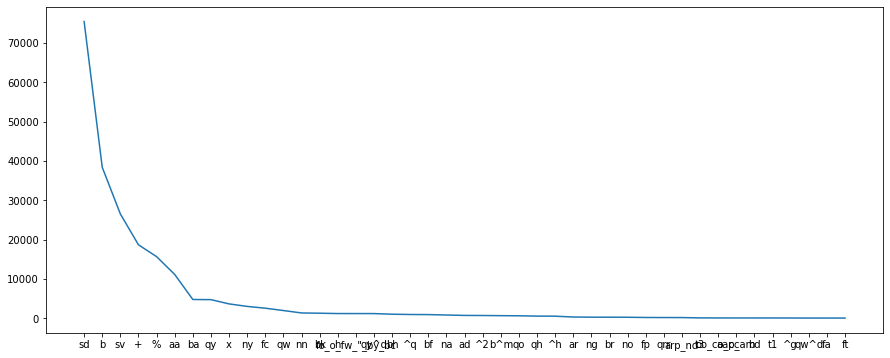

In [53]:
# Plot the frequencies of the classes
plt.figure(figsize=(15,6))
plt.plot(value_counts)

# Model 2 - Balanced Network


As the dataset is highly imbalanced, we can simply weight up the minority classes proportionally to their underrepresentation while training.

In [30]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(tags_encoding), y=tags_encoding)
print(class_weights)
d_class_weights = dict(enumerate(class_weights))
d_class_weights = list(d_class_weights.values())


[ 6.11062225  4.27291663  0.33159926 50.00134168 17.16217668 47.27399577
  3.97260469  6.91507917  5.27397519 44.44563705 50.4867916   5.41117537
  7.54737233  2.61313544 25.12144703 24.76256921 23.11173127 18.18230607
 66.66845558  1.09246629  1.41384979  7.12347881 49.52513843  0.13548734
  2.01165939  4.25543333  8.9967812   7.91497646  4.23809253 55.91547887
  3.77368616  9.33597762  0.06896462  0.27821623 65.82455107  1.71057222
  0.19603195 17.39177102 65.00174419  1.08403993  0.46608762 15.07286822
  4.91971574]


## Define & Train the model

In [31]:
"""
Task 2 2/2

Begin
"""
# Instantiate the model
model_balanced = BiLSTMModel(
    vocab_size=VOCAB_SIZE,
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    max_length=MAX_LENGTH
)


In [32]:
# Train the balanced network - Seems to take long time to achieve good accuracy?
train(model_balanced, train_dataset, val_dataset, 20, 1e-3, 256, device, d_class_weights)

Epoch [1/20] Train Loss: 0.0116, Train Acc: 0.2899 | Val Loss: 0.0102, Val Acc: 0.3741
Epoch [2/20] Train Loss: 0.0084, Train Acc: 0.3655 | Val Loss: 0.0090, Val Acc: 0.3420
Epoch [3/20] Train Loss: 0.0069, Train Acc: 0.3861 | Val Loss: 0.0088, Val Acc: 0.3624
Epoch [4/20] Train Loss: 0.0061, Train Acc: 0.4078 | Val Loss: 0.0088, Val Acc: 0.3588
Epoch [5/20] Train Loss: 0.0054, Train Acc: 0.4169 | Val Loss: 0.0087, Val Acc: 0.4040
Epoch [6/20] Train Loss: 0.0048, Train Acc: 0.4361 | Val Loss: 0.0089, Val Acc: 0.3817
Epoch [7/20] Train Loss: 0.0043, Train Acc: 0.4468 | Val Loss: 0.0091, Val Acc: 0.3300
Epoch [8/20] Train Loss: 0.0040, Train Acc: 0.4667 | Val Loss: 0.0093, Val Acc: 0.4125
Epoch [9/20] Train Loss: 0.0036, Train Acc: 0.4870 | Val Loss: 0.0098, Val Acc: 0.3921
Epoch [10/20] Train Loss: 0.0033, Train Acc: 0.5011 | Val Loss: 0.0104, Val Acc: 0.4315
Epoch [11/20] Train Loss: 0.0031, Train Acc: 0.5142 | Val Loss: 0.0104, Val Acc: 0.3902
Epoch [12/20] Train Loss: 0.0028, Train A

In [33]:
from collections import Counter
preds = np.argmax(label_pred, axis=1)
print(Counter(preds))


Counter({34: 25648, 1: 16501, 18: 10216, 17: 1347, 40: 1282, 13: 674, 33: 107, 0: 87, 26: 40})


## Test the model

In [54]:
# Overall Accuracy
eval(model_balanced, test_dataset, 100, device)


Overall Loss: 0.0159, Acc: 0.4953


In [55]:
# Generate predictions for the test data
label_pred = predict(model_balanced, test_dataset, 100, device)

## Balanced network evaluation

Report the overall accuracy and the accuracy of  'br' and 'bf'  classes. Suggest other ways to handle imbalanced classes.

In [40]:
def per_class_accuracy(confusion_matrix,class_idx):
  correct = confusion_matrix[class_idx][class_idx]
  total = sum(confusion_matrix[class_idx])
  return correct/total

index_br = tag_dict['br']
iindex_bf = tag_dict['bf']

In [41]:
# Build the confusion matrix off these predictions
preds = np.argmax(label_pred, axis=1)
matrix_balanced = confusion_matrix(y_test, preds)

# Calculate Accuracies for "br" and "bf"
print("br accuracy: " + str(per_class_accuracy(matrix_balanced,index_br)))
print("bf accuracy: " + str(per_class_accuracy(matrix_balanced,iindex_bf)))


"""
End Task 2 2/2
"""

br accuracy: 0.4318181818181818
bf accuracy: 0.1520912547528517


'\nEnd Task 2 2/2\n'





### Explanation



### Other ways to handle imbalanced classes


- The model can be turned into multiple single-class classifiers, giving a confidence score for each of the classes. Instead of just taking the highest confidence class, the model can run the individual classifiers in ascending order of frequency of the classes in the training corpus.  The first classifier to classify the data point over a certain confidence threshold determines the class given to the example. This gives chance for the minority class classifiers to classify before the frequent classes arrive with their more confident predicitions.

- Transfer Learning could also be implemented, to initialise weights on a larger dataset, where these minority classes may be prevelant. This would allow fine-tuning with the small data for this particular application.

Can we improve things by using context information?  Next we try to build a model which predicts DA tag from the sequence of
previous DA tags, plus the utterance representation.

# Using Context for Dialog Act Classification
We expect there is valuable sequential information among the DA tags. So in this section we apply a BiLSTM on top of the sentence CNN representation. The CNN model learns textual information in each utterance for DA classification. Here, we use bidirectional-LSTM (BLSTM) to learn the context before and after the current utterance.

To make it easier to train, we combined all of the utterances into one long sequence rather than breaking them up into individual dialogues.

## Define the model

This model has an architecture of:

- Word Embedding
- CNN
- Bidirectional LSTM
- Fully-Connected output


## CNN


This is classical CNN layer used to convolve over embedings tensor and gether useful information from it. The data is represented by hierarchy of features, which can be modelled using a CNN. We transform/reshape conv output to 2d matrix. Then we pass it to the max pooling layer that applies the max pool operation on windows of different sizes.

## BiLSTM

This is used to create LSTM layers. The data we’re working with has temporal properties which we want to model as well — hence the use of a LSTM. You should create a BiLSTM.
    

Concatenate 2 last layers and create the output layer
network

In [53]:
import torch.nn.functional as F

filter_sizes = [3,4,5]
num_filters = 64
drop = 0.2
VOCAB_SIZE = len(wordvectors)+1 # 43,731
MAX_LENGTH = 150
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags)

class CNN_BiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, filter_sizes, num_filters, dropout=0.2):
        super(CNN_BiLSTM, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size)

        # Convolution blocks (Conv2D + BatchNorm + ReLU), one per filter size
        self.conv_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels=1,
                          out_channels=num_filters,
                          kernel_size=(fs, embed_size),  # (filter_size, embedding_dim)
                          stride=1,
                          padding=0),
                nn.BatchNorm2d(num_filters),
                nn.ReLU()
            ) for fs in filter_sizes
        ])

        # After max pooling each convolution output, we concatenate them.
        # The shape after concatenation will be [batch_size, len(filter_sizes), 1, num_filters].
        # We'll flatten it to [batch_size, 1, len(filter_sizes)*num_filters].

        # First Dense layer (Dense_1) that maps CNN outputs down to EMBED_SIZE
        self.dense_1 = nn.Linear(num_filters * len(filter_sizes), embed_size)
        self.dropout_1 = nn.Dropout(dropout)

        # Two stacked BiLSTM layers
        # - The first BiLSTM has EMBED_SIZE hidden units, bidirectional => output_dim=2*EMBED_SIZE
        # - The second BiLSTM takes 2*EMBED_SIZE as input (from the first BiLSTM if return_sequences=True).
        #   Since it's bidirectional, final output_dim of the second BiLSTM is 2*EMBED_SIZE as well.
        self.blstm1 = nn.LSTM(input_size=embed_size, hidden_size=embed_size,
                              batch_first=True, bidirectional=True)
        self.blstm2 = nn.LSTM(input_size=2*embed_size, hidden_size=embed_size,
                              batch_first=True, bidirectional=True)

        # Second Dense layer (Dense_2) after the second BiLSTM
        # This projects 2*EMBED_SIZE down to EMBED_SIZE
        self.dense_2 = nn.Linear(2 * embed_size, embed_size)
        self.dropout_2 = nn.Dropout(dropout)

        # Final output layer (Output)
        self.output = nn.Linear(embed_size + embed_size, hidden_size)  # concatenating two EMBED_SIZE vectors

    def forward(self, x):
        """
        x shape: [batch_size, MAX_LENGTH]
        """
        # 1) Embedding
        x = self.embedding(x)               # [batch_size, MAX_LENGTH, EMBED_SIZE]
        x = x.unsqueeze(1)                  # [batch_size, 1, MAX_LENGTH, EMBED_SIZE] so we can apply Conv2D

        # 2) Parallel Convolutions -> BN -> ReLU -> MaxPool
        # Each conv_block expects input of shape [batch_size, 1, MAX_LENGTH, EMBED_SIZE].
        pooled_outputs = []
        for conv in self.conv_blocks:
            conv_out = conv(x)  # shape: [batch_size, num_filters, (MAX_LENGTH - fs + 1), 1]
            # Perform 2D max pooling across the variable spatial dimension conv_out.shape[2] and width=1
            # This collapses each feature map to a single value per filter.
            pooled = F.max_pool2d(conv_out, kernel_size=(conv_out.shape[2], conv_out.shape[3]))
            # Now shape: [batch_size, num_filters, 1, 1]
            pooled_outputs.append(pooled)

        """
        Task 3 1/2

        Begin
        """

        # Concatenate along the channel dimension (num_filters dimension)
        # After pooling, each block has shape [batch_size, num_filters, 1, 1].
        # concatenation => [batch_size, len(filter_sizes)*num_filters, 1, 1]
        x_cat = torch.cat(pooled_outputs, dim=1)

        # 3) Flatten to [batch_size, 1, len(filter_sizes)*num_filters]
        x_cat = x_cat.view(x_cat.size(0), 1, -1)


        # 4) Dense_1 + Dropout
        cnn_repr = self.dropout_1(self.dense_1(x_cat))

        # 5) BiLSTM_1 (return_sequences=True)
        #    Input shape: [batch_size, sequence_len, EMBED_SIZE]
        #    Output shape: [batch_size, sequence_len, 2*EMBED_SIZE]
        out, _ = self.blstm1(cnn_repr)

        # 6) BiLSTM_2 (no return_sequences => final hidden state)
        #    Input shape: [batch_size, sequence_len, 2*EMBED_SIZE]
        #    final_timestep shape: [2, batch_size, EMBED_SIZE]
        out2, (h_n, c_n) = self.blstm2(out)

        #getting final hidden states and concatenating them
        blstm_repr = torch.cat((h_n[0], h_n[1]), dim=1)
        # 7) Dense_2 + Dropout

        blstm_out = self.dropout_2(self.dense_2(blstm_repr))

        # 8) Concatenate Flatten(dropout_1) and dropout_2
        #    Flatten(dropout_1) => shape [batch_size, EMBED_SIZE]
        #    out => [batch_size, EMBED_SIZE]
        # Note: dropout_1 was [batch_size, 1, EMBED_SIZE], so flatten the second dimension:

        cnn_flat = cnn_repr.squeeze(1)
        combined = torch.cat((cnn_flat, blstm_out), dim=1) 
        # 9) Output layer
        logits = self.output(combined)

        """
        End Task 3 1/2
        """
        return logits

model_context = CNN_BiLSTM(
    vocab_size=VOCAB_SIZE,
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    filter_sizes=filter_sizes,
    num_filters=num_filters,
    dropout=drop
)
print(model_context)

CNN_BiLSTM(
  (embedding): Embedding(43732, 100)
  (conv_blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 100), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 100), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(1, 64, kernel_size=(5, 100), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (dense_1): Linear(in_features=192, out_features=100, bias=True)
  (dropout_1): Dropout(p=0.2, inplace=False)
  (blstm1): LSTM(100, 100, batch_first=True, bidirectional=True)
  (blstm2): LSTM(200, 100, batch_first=True, bidirectional=True)
  (dense_2): Linear(in_features=200, out_features=100, bias=True)
  (dropout_2): Dr

Report your overall accuracy. Did context help disambiguate and better predict the minority classes ('br' and 'bf')? What are frequent errors? Show one positive example where adding context changed the prediction.
layer

In [57]:
"""
Task 3 2/2

Begin
"""
train(model_context, train_dataset=train_dataset,val_dataset=val_dataset,epoch_num=5,lr=1e-3,batch_size=256,device=device,weight=None)
eval(model_balanced, test_dataset, 100, device)

label_pred_context = predict(model_context, test_dataset, batch_size=256, device=device)
preds_context = np.argmax(label_pred_context, axis=1)
matrix_context = confusion_matrix(y_test, preds_context)

# Calculate Accuracies for "br" and "bf"
print("br accuracy: " + str(per_class_accuracy(matrix_context,index_br)))
print("bf accuracy: " + str(per_class_accuracy(matrix_context,iindex_bf)))

#samples
inv_tag_dict = {v: k for k, v in tag_dict.items()}

for i in range(len(y_test)):
    if preds[i] != y_test[i] and preds_context[i] == y_test[i]:
        print(f"Sentence index: {i}")
        print(f"True label: {inv_tag_dict[y_test[i]]}")
        print(f"Base model prediction: {inv_tag_dict[preds[i]]}")
        print(f"Context model prediction: {inv_tag_dict[preds_context[i]]}")
        break
"""
End Task 3 2/2
"""

Epoch [1/5] Train Loss: 0.0043, Train Acc: 0.6677 | Val Loss: 0.0043, Val Acc: 0.6584
Epoch [2/5] Train Loss: 0.0038, Train Acc: 0.7019 | Val Loss: 0.0041, Val Acc: 0.6699
Epoch [3/5] Train Loss: 0.0035, Train Acc: 0.7199 | Val Loss: 0.0040, Val Acc: 0.6752
Epoch [4/5] Train Loss: 0.0032, Train Acc: 0.7354 | Val Loss: 0.0041, Val Acc: 0.6731
Epoch [5/5] Train Loss: 0.0031, Train Acc: 0.7486 | Val Loss: 0.0040, Val Acc: 0.6822
Overall Loss: 0.0159, Acc: 0.4953
br accuracy: 0.38636363636363635
bf accuracy: 0.0
Sentence index: 6
True label: %
Base model prediction: fc
Context model prediction: %


'\nEnd Task 3 2/2\n'

In [58]:
for i in range(len(matrix_context)):
    class_name = inv_tag_dict[i]
    correct = matrix_context[i][i]
    total = matrix_context[i].sum()
    if total > 0:
        accuracy = correct / total * 100
        print(f"Class '{class_name}' → Accuracy: {accuracy:.2f}% ({correct}/{total})")


Class 'na' → Accuracy: 0.00% (0/197)
Class 'qy^d' → Accuracy: 6.27% (21/335)
Class '%' → Accuracy: 73.21% (2686/3669)
Class 'bd' → Accuracy: 28.57% (6/21)
Class 'ng' → Accuracy: 7.87% (7/89)
Class 'oo_co_cc' → Accuracy: 21.74% (5/23)
Class 'bk' → Accuracy: 42.09% (157/373)
Class 'ad' → Accuracy: 14.56% (30/206)
Class '^q' → Accuracy: 1.23% (3/244)
Class 't3' → Accuracy: 12.50% (2/16)
Class 't1' → Accuracy: 33.33% (6/18)
Class 'bf' → Accuracy: 0.00% (0/263)
Class 'b^m' → Accuracy: 1.10% (2/181)
Class 'qw' → Accuracy: 74.42% (387/520)
Class 'arp_nd' → Accuracy: 0.00% (0/47)
Class 'qrr' → Accuracy: 71.70% (38/53)
Class 'fp' → Accuracy: 40.91% (27/66)
Class 'no' → Accuracy: 1.32% (1/76)
Class 'ft' → Accuracy: 21.74% (5/23)
Class 'qy' → Accuracy: 69.61% (852/1224)
Class 'x' → Accuracy: 93.94% (822/875)
Class '^2' → Accuracy: 6.45% (10/155)
Class 'aap_am' → Accuracy: 0.00% (0/29)
Class 'b' → Accuracy: 93.66% (8736/9327)
Class 'fc' → Accuracy: 51.08% (285/558)
Class 'fo_o_fw_"_by_bc' → Accura

In [59]:
# index → word
reversed_wordvectors = {v: k for k, v in wordvectors.items()} 
# index → tag 
index_to_tag = {v: k for k, v in tag_dict.items()}             

preds_base = np.argmax(label_pred, axis=1)
preds_context = np.argmax(label_pred_context, axis=1)

for i in range(len(y_test)):
    gold = y_test[i]
    base = preds_base[i]
    context = preds_context[i]

    tag = index_to_tag[gold]

    # 'br' or 'bf' sentences that were misclassified by base, but correctly by context
    if gold == context and base != gold and tag in ["br", "bf"]:
        tokens = [reversed_wordvectors.get(w, "<UNK>") for w in test_sentences_X[i] if w != 0]
        sentence = " ".join(tokens)

        print(f"Fixed by Context Model:")
        print(f" Sentence: {sentence}")
        print(f" True Label:      {tag}")
        print(f" Base Predicted:  {index_to_tag[base]}")
        print(f" Context Predicted: {index_to_tag[context]}\n")

Fixed by Context Model:
 Sentence: Excuse me. /
 True Label:      br
 Base Predicted:  ad
 Context Predicted: br

Fixed by Context Model:
 Sentence: Pardon me. /
 True Label:      br
 Base Predicted:  qy^d
 Context Predicted: br

Fixed by Context Model:
 Sentence: <Throat_clearing> The ones that what? /
 True Label:      br
 Base Predicted:  qy^d
 Context Predicted: br

